
# Quarter 2: Project
The main deliverable for the second quarter of the computational economics and finance class is a project to showcase what you have learned. The goal of this project is for you (potentially in a small group) to produce a piece of work (in the form of a Jupyter notebook) that you would be able to use to showcase the skills that you have learned in this class to potential employers or academic advisors.

The relatively loose structure in self-directed projects like this makes them a bit more challenging than other things that you will do in school, but we think it also makes them more interesting. They give you a chance to indulge your curiosity and show off your creativity.

We have broken the project into three components to keep you on track. Each of these components should be turned in as its own Jupyter notebook. The first two steps are graded almost entirely on whether you do them or not. You must complete the first two steps on your own. When you actually begin working on the final project, you may work in groups of two to four, but you may also work alone if you’d  prefer.

## Project Ideas

**(15% of project grade)**

Form a team of between one and four students (no more) and choose a project. This project could come from the ideas that you submitted or some other idea if you get a sudden flash of inspiration. Flesh out the project in detail -- When we say “flesh it out in detail”, we mean properly load the data into the notebook, describe in words what you want to explore, and create a couple draft quality visualizations (don’t worry about making them pretty) that whets a reader’s appetite.

Please include the names of all group members in the below:

* Jian Zhou
* Bo Sun
* Man Chen


**Please note that each person should make a copy of the notebook and turn it in!**


## Proposal:

Include your project proposal, data, and graphs in the cells below

### Project Proposal

The stochastic volatility model is the canonical method to model asset return volatility. Nonetheless, the stochastic models usually don’t have closed-form analytic solution and computational-heavy to calibrate due to model complexity. Monte Carlo Markov Chain has grown to be one of the most effective and popular tools in analyzing the stochastic volatility model. Priors and data are fed into the model, and posteriors are the calibrated model parameters of interest. 

We have noticed that the VIX index has been rather volatile since the outbreak of COVID-19 and peaked in March 2019. The traditional stochastic volatility fails to capture the spike due to the inactivity to internalize exogenous shock.  

We proposed to extend the canonical stochastic volatility to incorporate covid-19 data under a Monte Carlo Markov Chain framework. The following formulas set the extended stochastic volatility model.

Mathematically speaking, the cannonical stochastic volatility model follows the below setting, where $\sigma_\eta$ is the scale parameter.

\begin{align*}
\qquad & y_t = \beta e^{h_t/2} \epsilon_t\qquad \qquad &\epsilon_t \sim N(0,1) \\
\qquad & h_{t} = \mu + \phi (h_{t-1} - \mu) + \sigma_{\eta} \eta_{t}  \qquad \qquad &\eta_{t-1} \sim N(0,1) \quad \beta \sim N(1,10) \\
\qquad &  h_1 \sim N(\mu, \sigma_\eta^2/(1-\phi^2)) \\
\end{align*}

The extended stochastic volatility model follows the below setting. The key difference is that $\sigma_\eta$ is no more time-invariant, instead, is a random walk with drift decided by covid-19 data.

\begin{align*}
\qquad & y_t = \beta e^{h_t/2} \epsilon_t\qquad \qquad &\epsilon_t \sim N(0,1) \\
\qquad & h_{t} = \mu + \phi (h_{t-1} - \mu) + \sigma_{\eta,t-1} \eta_{t-1}  \qquad \qquad &\eta_{t-1} \sim N(0,1) \quad \beta \sim N(1,10) \\
\qquad &  h_1 \sim N(\mu, \sigma_\eta^2/(1-\phi^2)) \\
\qquad & \color{red}{ \sigma_{\eta,t} =  \sigma_{\eta,t-1} + \alpha(lnC_t - lnC_{t-1}) + u_t} \qquad \qquad &u_t \sim N(0,1) \\
\qquad &  \color{red} {\sigma_{\eta,1} \sim N(1, 10)}
\end{align*}

We plan to sample and calibrate the extended stochastic volatility model. Furthermore, we will conduct a model comparison to check whether the comprehensive model supersedes the canonical model. 

In [1]:
import arviz as az
import autoreload
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import pickle
import yfinance as yf

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 1

### Data

We load financial data from yahoo finance

In [4]:
# load sp500 and vix data use yfinance
_finance_data = yf.download("^GSPC ^VIX", start="2017-01-01", end="2021-01-11")['Adj Close']
_finance_data = _finance_data.rename({'^GSPC':'SP500', '^VIX':'VIX', '^INDIAVIX':'India_VIX'}, axis=1)
_finance_data.head(2)

[*********************100%***********************]  2 of 2 completed


,SP500,VIX
Date,,
2017-01-03,2257.830078,12.85
2017-01-04,2270.750000,11.85


In [5]:
VIX_india = pd.read_csv("indian vix.csv").pipe(pd.DataFrame.rename, columns=lambda x: x.strip()) \
.pipe(pd.DataFrame.rename, {'Close':'India_VIX'}, axis=1) \
.pipe(pd.DataFrame.set_index, ['Date']) \

VIX_india.index = VIX_india.reset_index()['Date'].apply(lambda i : datetime.datetime.strptime(i, '%d-%b-%y'))
finance_data = _finance_data.merge(VIX_india, left_index=True, right_index=True)
finance_data.head(2)

,SP500,VIX,India_VIX
Date,,,
2019-02-28,2784.489990,14.78,18.2775
2019-03-01,2803.689941,13.57,16.2750


We load covid-19 data from Johns Hopkins Coronavirus Resource Center.
The raw data is taken a gaussian smoothing with a 2-week window size and standard deviation 3.

In [6]:
# load covid-19 data from Johns Hopkins Coronavirus Resource Center
_covid_19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv",
           error_bad_lines=False)


covid_19 = _covid_19.pipe(pd.DataFrame.drop, ['Province/State', 'Lat', 'Long'], 1) \
        .pipe(pd.DataFrame.set_index, 'Country/Region').T
        
covid_19['global'] = covid_19.apply('sum', axis=1)

# calculate the cases growth in each country
covid_19_country = pd.DataFrame(index=covid_19.index)
for country in covid_19.columns.unique():
        covid_19_country['cases_growth_' + country] = np.log(covid_19[[country]].sum(axis=1).replace(0,1)).diff().rolling(14, win_type='gaussian').mean(std=3)                                  


# # calculate the cases growth in US
# covid_19['cases_growth_US'] = np.log(covid_19['US']).diff().rolling(14, win_type='gaussian').mean(std=3)


# calculate the cases growth globally
covid_19_country['cases_growth_global'] = covid_19_country.mean(axis=1)

covid_19_data = covid_19[['US', 'global']].merge(covid_19_country[['cases_growth_US', 
                                                                   'cases_growth_global', 
                                                                   'cases_growth_India']], 
                                                 left_index=True, right_index=True)


covid_19_data.index = covid_19_data.reset_index()['index'].apply(lambda i : datetime.datetime.strptime(i, '%m/%d/%y'))
covid_19_data.tail(2)

,US,global,cases_growth_US,cases_growth_global,cases_growth_India
index,,,,,
2021-01-27,25598061,100866032,0.007188,0.007733,0.001291
2021-01-28,25766681,101457552,0.006974,0.007625,0.001284


In [7]:
# merge data 
data = finance_data.merge(covid_19_data, left_index=True, right_index=True)
data.tail(2)

,SP500,VIX,India_VIX,US,global,cases_growth_US,cases_growth_global,cases_growth_India
2021-01-06,3748.139893,25.070000,20.995,21393464,87283880,0.010412,0.007972,0.001808
2021-01-07,3803.790039,22.370001,20.615,21670202,88141868,0.010607,0.008094,0.001822
2021-01-08,3824.679932,21.559999,20.640,21962246,88963363,0.010814,0.008285,0.001823


### Graphs

#### VIX peaks at March, 2020, as the covid-19 panics the street.
Furthermore, we notice that VIX sicne covid-19 has been stably higher than before, implying some systematic change.

<AxesSubplot:xlabel='Date'>

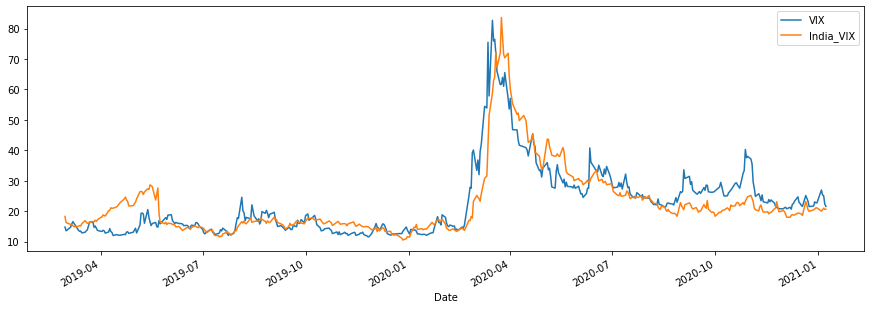

In [8]:
finance_data.plot(y=['VIX', 'India_VIX'], use_index=True, figsize=(15,5))

#### The log-difference of the confirmed cases of covid-19 (2-week gaussian smoothed) spiked in March, 2020 in US and around the world.

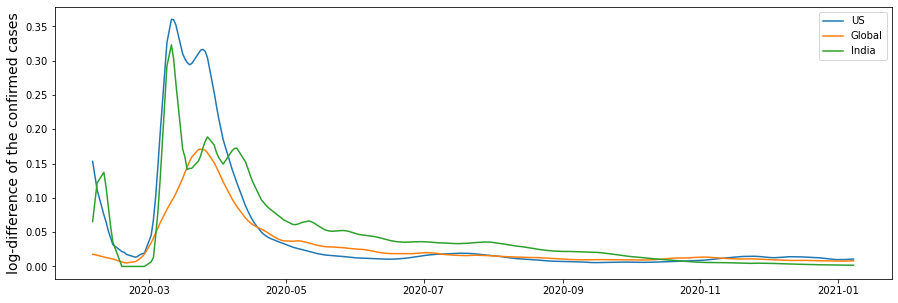

In [9]:
fig,ax = plt.subplots(figsize=(15,5))
# make a plot
ax.plot(data.index, data.loc[:, 'cases_growth_US'], label="US")
ax.plot(data.index, data.loc[:, 'cases_growth_global'], label="Global")
ax.plot(data.index, data.loc[:, 'cases_growth_India'], label="India")
ax.set_ylabel("log-difference of the confirmed cases", fontsize=14)
plt.legend()

#### There is a salient overlap in March, 2020, if we plot VIX and the log-difference of the confirmed cases together.

The common co-movements inspire our project idea - incorporating covid-19 data with the stochastic model. We believe the overlap of peaks is not by coincidence, while indeed, covid-19 cases can provide some insightful information about the scale parameter $\sigma_\eta$

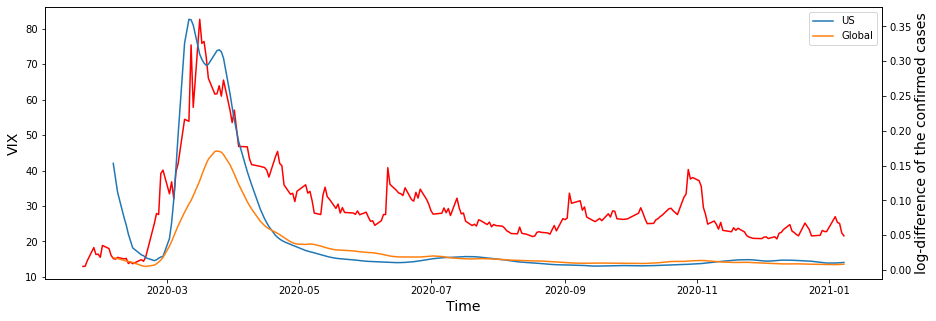

In [10]:
fig,ax = plt.subplots(figsize=(15,5))
# make a plot
ax.plot(data.index, data.VIX, color="red")
# set x-axis label
ax.set_xlabel("Time", fontsize=14)
# set y-axis label
ax.set_ylabel("VIX", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data.index, data['cases_growth_US'], label="US")
ax2.plot(data.index, data['cases_growth_global'], label='Global')
ax2.set_ylabel("log-difference of the confirmed cases", fontsize=14)
plt.legend()
plt.show()

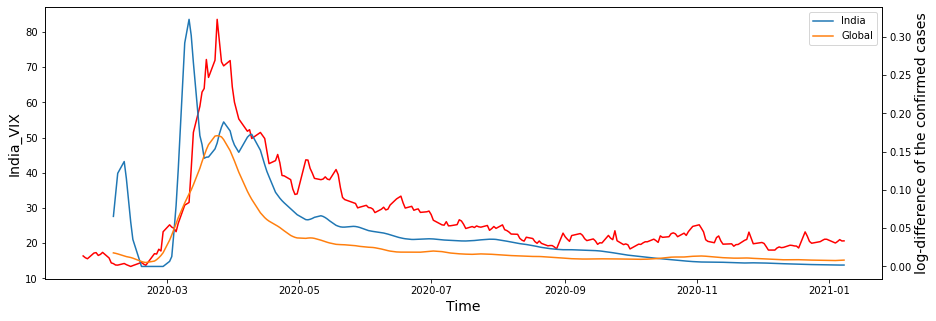

In [11]:
fig,ax = plt.subplots(figsize=(15,5))
# make a plot
ax.plot(data.index, data.India_VIX, color="red")
# set x-axis label
ax.set_xlabel("Time", fontsize=14)
# set y-axis label
ax.set_ylabel("India_VIX", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data.index, data['cases_growth_India'], label="India")
ax2.plot(data.index, data['cases_growth_global'], label='Global')
#ax2.plot(data.index, data['cases_growth_India'], label='India')
ax2.set_ylabel("log-difference of the confirmed cases", fontsize=14)
plt.legend()
plt.show()

### From Random Walk to AR-X - The Evolution of Stochastic Volatility Model

### Baseline Model: RW Stochastic Volatility

We start from the most basic stochastic volatility model, namely,
volatility follows a random walk latent process without any exogenous
variables.

Mathamatically speaking,

\begin{align*}
\qquad & y_t = \beta e^{h_t/2} \epsilon_t\qquad \qquad &\epsilon_t \sim N(0,1) \\
\qquad & h_{t} = \mu + \phi (h_{t-1} - \mu) + \sigma_{\eta} \eta_{t}  \qquad \qquad &\eta_{t} \sim N(0,1) \\
\end{align*}

We use an informative prior, setting $\beta = 1$ and $\mu = 0$ to facilitate
computation and subsequent analysis.
##### Model Setting
The likelihood is given by
\begin{align*}
\qquad & log(y_t) \sim StudentT(\nu,0, e^{h_t}) \\
\end{align*}

The priors are given by
\begin{align*}
\qquad & \nu \sim Exp(0.1) \\
\qquad & \sigma_\eta \sim Exp(10) \\
\qquad & h_{t} = h_{t-1} + \sigma_{\eta}* \eta_{t}   \\
\end{align*}

We use NUTS to sample the Random Walk Model.

Also we define some common-used utils functions.

In [3]:
# Utils Functions

def load_data(regular = True, reload=False):
    '''
    prepare data for the project
    :param regular: for developers only
    :param reload: reload data online
    :return: a dataframe
    '''
    if not reload:
        if os.path.exists("../Data/data.pkl"):
            data = pd.read_pickle("../Data/data.pkl")
            return data
        else:
            return load_data(reload=True)

    # load sp500 and vix data use yfinance
    _finance_data = yf.download("^GSPC ^VIX", start="2017-01-01", end="2021-01-11")['Adj Close']
    _finance_data = _finance_data.rename({'^GSPC':'SP500', '^VIX':'VIX', '^INDIAVIX':'India_VIX'}, axis=1)
    _finance_data['log_returns'] = np.log(_finance_data['SP500']).diff()
    _finance_data['returns'] = _finance_data['SP500'].pct_change()
    _finance_data['real_3w_vol'] = _finance_data['returns'].rolling(window=15).apply(pd.DataFrame.std)

    try:
        VIX_india = pd.read_csv("indian vix.csv").pipe(pd.DataFrame.rename, columns=lambda x: x.strip()) .pipe(
            pd.DataFrame.rename, {'Close':'India_VIX'}, axis=1) .pipe(pd.DataFrame.set_index, ['Date'])
    except FileNotFoundError:
        VIX_india = pd.read_csv("../indian vix.csv").pipe(pd.DataFrame.rename, columns=lambda x: x.strip()).pipe(
            pd.DataFrame.rename, {'Close': 'India_VIX'}, axis=1).pipe(pd.DataFrame.set_index, ['Date'])
    VIX_india.index = VIX_india.reset_index()['Date'].apply(lambda i : datetime.datetime.strptime(i, '%d-%b-%y'))
    finance_data = _finance_data.merge(VIX_india, left_index=True, right_index=True)



    # We load covid-19 data from Johns Hopkins Coronavirus Resource Center.
    # The raw data is taken a gaussian smoothing with a 2-week window size and standard deviation 3.


    # load covid-19 data from Johns Hopkins Coronavirus Resource Center
    # code for Bo Sun only
    if regular:
        _covid_19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv",
                error_bad_lines=False)
    else:
        _covid_19 = pd.read_csv(r"C:\Users\harvey_sun\Desktop\data\time_series_covid19_confirmed_global.csv")


    covid_19 = _covid_19.pipe(pd.DataFrame.drop, ['Province/State', 'Lat', 'Long'], 1)         .pipe(pd.DataFrame.set_index, 'Country/Region').T

    covid_19['global'] = covid_19.apply('sum', axis=1)

    # calculate the cases growth in each country
    covid_19_country = pd.DataFrame(index=covid_19.index)
    for country in covid_19.columns.unique():
            covid_19_country['cases_growth_' + country] = np.log(covid_19[[country]].sum(axis=1).replace(0,1)).diff().rolling(14, win_type='gaussian').mean(std=3)

    # calculate the cases growth globally
    covid_19_country['cases_growth_global'] = covid_19_country.mean(axis=1)

    covid_19_data = covid_19[['US', 'global']].merge(covid_19_country[['cases_growth_US',
                                                                       'cases_growth_global',
                                                                       'cases_growth_India']],
                                                     left_index=True, right_index=True)
    # set covid state for US, use 0.05 as threshold line
    covid_19_data.loc[:, 'covid_state_US'] = 0
    covid_19_data.loc[covid_19_data.cases_growth_US > 0.05, 'covid_state_US'] = 1

    covid_19_data.index = covid_19_data.reset_index()['index'].apply(lambda i : datetime.datetime.strptime(i, '%m/%d/%y'))

    # merge data
    data = finance_data.merge(covid_19_data, left_index=True, right_index=True)
    if not os.path.exists("../Data"):
        os.mkdir("../Data")
    data.to_pickle("../Data/data.pkl")
    return data

def model_diagnose(model, trace, var_names):
    '''
    diagnose a model based on 'Effective Sample Size and Rhat

    :param model: a PyMC3 model
    :param trace: sample trace
    :param var_names: variable names
    :return: None
    '''
    ess = az.ess(trace, relative=True)

    print("Effective Sample Size (min across parameters)")
    for var in var_names:
        print(f"\t{var}: {ess[var].values.min()}")
    rhat = az.rhat(trace)

    print("rhat (max across parameters)")
    for var in var_names:
        print(f"\t{var}: {rhat[var].values.max()}")

def gen_xy(trace, _data, y="log_vol", AR=False, skip=5):
    '''
    generate posterior predictive y from trace

    :param trace: sample trace
    :param _data: observation data
    :param y: y column anme
    :param AR: whether it's a AR model
    :param skip: how often take draws from trace, only take 1 draw after skip steps
    :return: x values from observation data, y values from posterior predictive
    '''
    _y_vals = np.exp(trace.posterior[y])
    y_vals = np.vstack([_y_vals[i] for i in range(_y_vals.shape[0])]).T
    if AR:  # take the last n-1 values, because AR1 process has an extra starting point
        y_vals = y_vals[:-1, ]
    # only take 1 draw after skip steps
    y_vals = y_vals.T[::skip].T
    x_vals = np.vstack([_data.index for _ in y_vals.T]).T.astype(np.datetime64)
    return x_vals, y_vals

def model_plot(data, trace, pp, AR=False):
    '''
    plot returns and volatility
    :param data: observation data
    :param trace: sample trace
    :param pp: posterior predictive
    :param AR: whether it's a AR model
    :return: figures
    '''
    x = data.index.to_numpy().astype(np.datetime64)
    fig, ax = plt.subplots(2, 1, figsize=(14, 8))

    # Plot returns
    ax[0].plot(
        x, pp["returns"][::10].T, color="g",
        alpha=0.25, zorder=-10
    )
    ax[0].plot(x, data["log_returns"].to_numpy(), color="k", linewidth=2.5, label="log returns")
    ax[0].set(title="Posterior predictive log-returns (green) VS actual log-returns", ylabel="Log Returns")

    # Plot volatility
    _, y_vals = gen_xy(trace, data, AR=AR, skip=10)
    ax[1].plot(x, y_vals, "k", alpha=0.01)
    ax[1].plot(data.index, data['real_3w_vol'], linewidth=2.5, label="realized 3W vol")
    ax[1].set(title="Estimated volatility over time (balck) vs realized vol", ylabel="Volatility")
    ax[1].set_ylim(bottom=0)

    # Add legends
    ax[0].legend(loc="upper right")
    ax[1].legend(loc="upper right")
    plt.tight_layout()

data = load_data(reload=True)

[*********************100%***********************]  2 of 2 completed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_vol, scale, nu]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 121 seconds.
The number of effective samples is smaller than 10% for some parameters.


Effective Sample Size (min across parameters)
	nu: 0.9135385336981048
	scale: 0.03319699489264997
rhat (max across parameters)
	nu: 1.0002554830588706
	scale: 1.0136860678998891


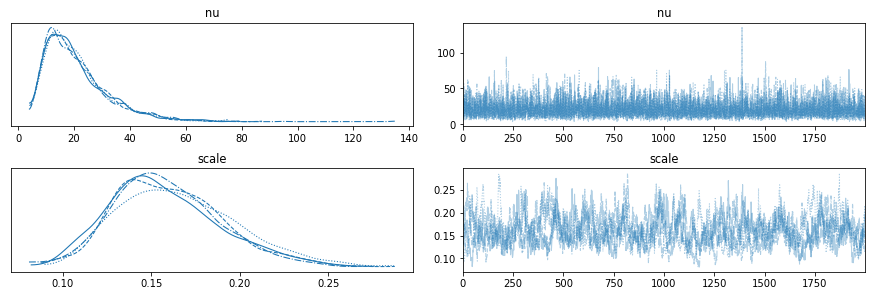

In [4]:
# Code for Random Walk
# %aimport stovol.baseline
# baseline_model_RW = stovol.baseline.make_baseline_model_RW(data, "log_returns")

def make_baseline_model_RW(data, observe):
    '''model for Random Walk StoVol'''
    with pm.Model() as model:
        # Piror
        nu = pm.Exponential("nu", 0.1)
        scale = pm.Exponential("scale", 10)
        log_vol = pm.GaussianRandomWalk("log_vol", sigma=scale, shape=len(data))
        # Likelihood
        returns = pm.StudentT("returns", nu=nu, lam=np.exp(-2 * log_vol), observed=data[observe])
    return model

baseline_model_RW = make_baseline_model_RW(data, "log_returns")

with baseline_model_RW:
    trace_RW = pm.sample(2000, tune=2000, return_inferencedata=True)
    _var_names = ['nu', 'scale']
    model_diagnose(baseline_model_RW, trace_RW, _var_names)
    az.plot_trace(trace_RW, var_names=_var_names)
    pp_RW = pm.sample_posterior_predictive(trace_RW)

We plot the posterior predictive returns and volatility.

There are 4 chains and each chian have 2000 steps.

We take every 5th of the draws and yield 1600 paths.

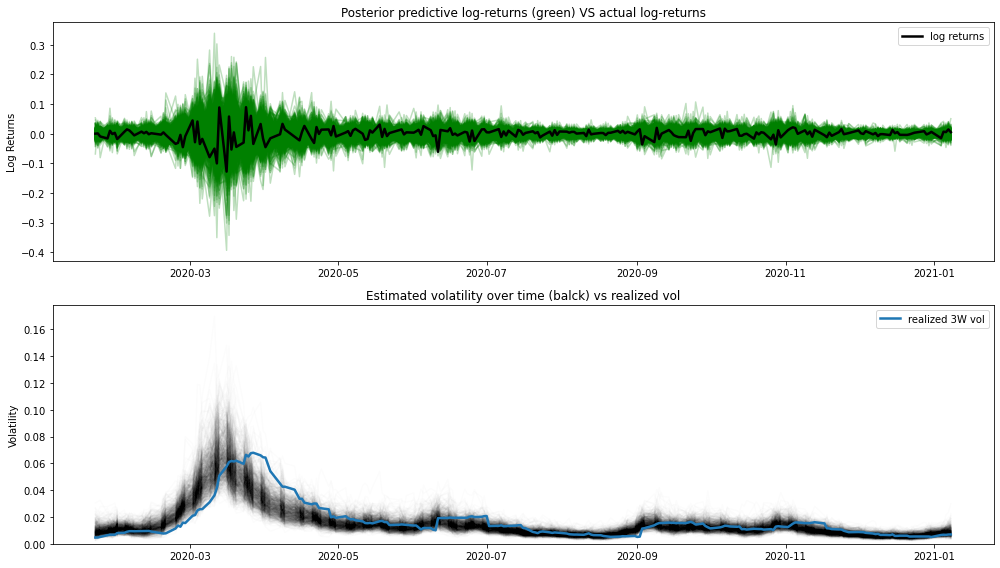

In [5]:
model_plot(data=data, trace=trace_RW, pp=pp_RW)

### Model Extension: AR1 Stochastic Volatility

Recall the stochastic volatility model is defined by,

\begin{align*}
\qquad & y_t = e^{h_t/2} \epsilon_t\qquad \qquad &\epsilon_t \sim N(0,1) \\
\qquad & h_{t} - \mu= \phi(h_{t-1} - \mu) + \sigma_{\eta} \eta_{t}  \qquad \qquad &\eta_{t} \sim N(0,1) \\
\end{align*}

The Random Walk Stochastic Volatility Model coerces the correlation
between $h_{t}$ and $h_{t-1}$ to be 1 (in our case, $\phi=1$).

However, it doesn't have to
be 1, and hence, we free up that parameter and change the model
setting to be a AR1 process.

Note that $\mu$ is not being set to 0 (like what we have done in
Random Walk Stochastic Volatiltiy Model), instead, we treat $\mu$
as a model parameter to fit.

##### Model Setting
The likelihood is given by
\begin{align*}
\qquad & log(y_t) \sim StudentT(\nu,\mu, e^{h_t}) \\
\end{align*}

The priors are given by
\begin{align*}
\qquad & \nu \sim Exp(0.1) \\
\qquad & \phi \sim \mathcal{N}(0, 1) \\
\qquad & \sigma_\eta \sim Exp(10) \\
\qquad & \mu \sim \mathcal{N}(0, 1) \\
\qquad & h_{t} - \mu = \phi(h_{t-1} - \mu)+ \sigma_\eta* \eta_{t}   \\
\end{align*}

We beef up the tuning iterations from 2k to 4k as the model complexity increases.

Also, we hardcode the random seed as 1234 to avoid initialization failure.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, mean_return, mu, _log_vol, scale, phi]
Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 180 seconds.
There were 1033 divergences after tuning. Increase `target_accept` or reparameterize.
There were 637 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1225 divergences after tuning. Increase `target_accept` or reparameterize.
There were 320 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Effective Sample Size (min across parameters)
	mean_return: 0.4311473395354691
	phi: 0.013587463284116884
	scale: 0.025461784367024252
	mu: 0.0034058995208666636
	nu: 0.2543067441361843
rhat (max across parameters)
	mean_return: 1.0020055735842137
	phi: 1.0373445758443407
	scale: 1.0284540451279893
	mu: 1.1256700689969974
	nu: 1.0020219412446298


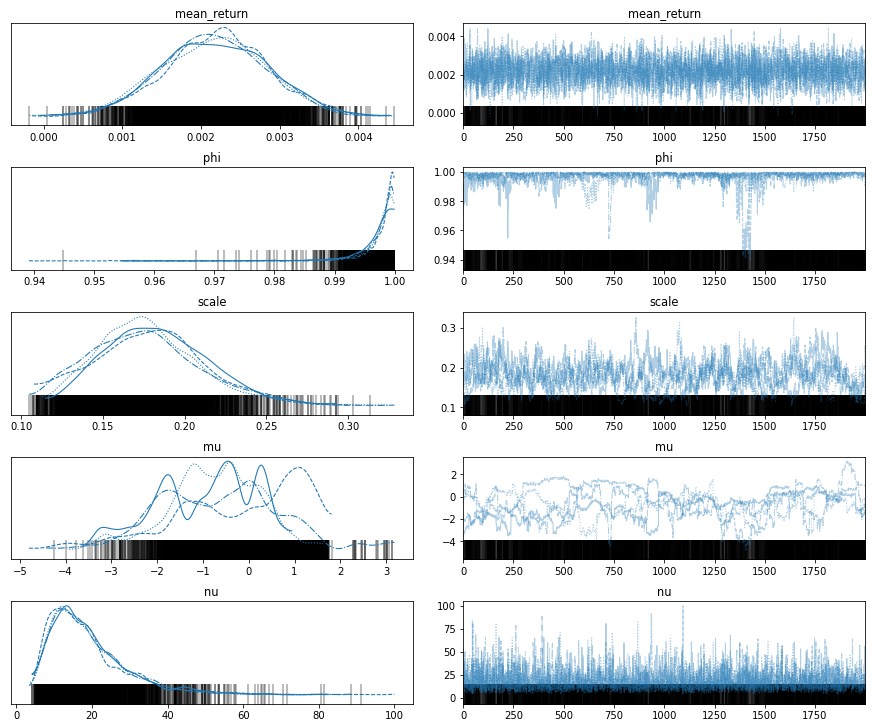

In [6]:
# Code for AR1
def make_baseline_model_AR1(data, observe):
    '''
    model for AR1 StoVol

    :param data: observation data
    :param observe: column name of y
    :return: PyMC model
    '''
    with pm.Model() as model:
        # Piror
        # phi = pm.Beta("phi", alpha=20, beta=1.5)
        np.random.seed(12345)
        phi = pm.Normal("phi", mu=1, sigma=1, testval=np.random.randn())
        # scale = pm.InverseGamma("scale", alpha=2.5, beta=0.05)
        scale = pm.Exponential("scale", 10, testval=np.random.randn())
        _log_vol = pm.AR1("_log_vol", k=phi, tau_e=1/pm.math.sqr(scale), shape=len(data), testval=np.random.randn(len(data)))
        # mu = pm.Exponential('mu', lam=0.1)
        mu = pm.Normal('mu', mu=0, sigma=1)
        log_vol = pm.Deterministic("log_vol", _log_vol + mu)
        mean_return = pm.Normal("mean_return", 0, 1)
        nu = pm.Exponential("nu", 0.1)
        # Likelihood
        # returns = pm.Normal("returns", mu=mean_return, sigma=np.exp(log_vol/2), observed=data[observe])
        returns = pm.StudentT("returns", nu=nu, mu=mean_return, lam=np.exp(-2 * log_vol), observed=data[observe])
    return model

baseline_model_AR = make_baseline_model_AR1(data, "log_returns")

with baseline_model_AR:
    trace_AR = pm.sample(2000, tune=4000, return_inferencedata=True)
    _var_names = ["mean_return", "phi", "scale", "mu", "nu"]
    model_diagnose(baseline_model_AR, trace_AR, _var_names)
    az.plot_trace(trace_AR, var_names=_var_names)
    pp_AR = pm.sample_posterior_predictive(trace_AR)

<pre>
Simplicity is the ultimate sophistication.
                                --Leonardo da Vinci
</pre>
The posterior distributions echo the Leonardo da Vinci famous saying.

Even though we have allowed more free parameters in the model, neither do we
receive noticeable model improvements as shown in graphs below compared to the
more parsimonious random walk model, nor do the posteriors distrubtions provide
sufficient evidences.

The posteriors of mean_return center around 0.002, $\phi$ cluster at 1 and $\mu$
is spreading across the support.

This results shows that assumptions under classical stochastic
volatility model are mostly reasonable and supported by empirical data.
To be more specific, mean of log-return is 0, log-volatility is a
random walk process and the mean of log-volatility is 0.

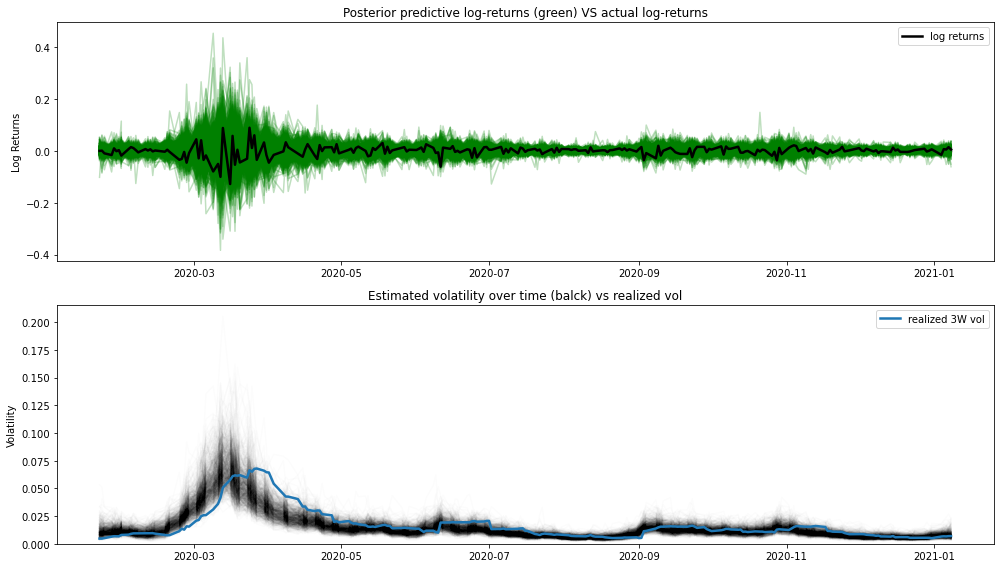

In [7]:
model_plot(data=data, trace=trace_AR, pp=pp_AR)

### Model Extension: Two-State AR1 Stochastic Volatility

Recall the stylized fact that COVID-19 greatly impacts realized and implied
volatility and market indices per se, which motivate us to incorporate COVID data
in volatility analysis.

We initiate a two-stage model - high-vol stage and low-vol stage,
which is identifed by COVID-19. A period with high COVID
infection number is in high-vol state, while a period with low COVID
infection is in low-vol state.

##### Model Setting
The likelihood is given by
\begin{align*}
\qquad & log(y_t) \sim StudentT(\nu,\mu, e^{h_t}) \\
\end{align*}

The priors are given by
\begin{align*}
\qquad & \nu \sim Exp(0.1) \\
\qquad & \phi \sim \mathcal{N}(0, 1) \\
\qquad & scale \sim Exp(10) \\
\qquad & h_{t} = \phi h_{t-1}+ scale_s* \epsilon_{t} \qquad s \in (low\_vol, high\_vol)  \\
\end{align*}

Exploring with the method of trial and errors, we argue that log-difference
log-difference of the confirmed cases being 5% is a decent cut-off point to seperate
high-vol and low-vol state.

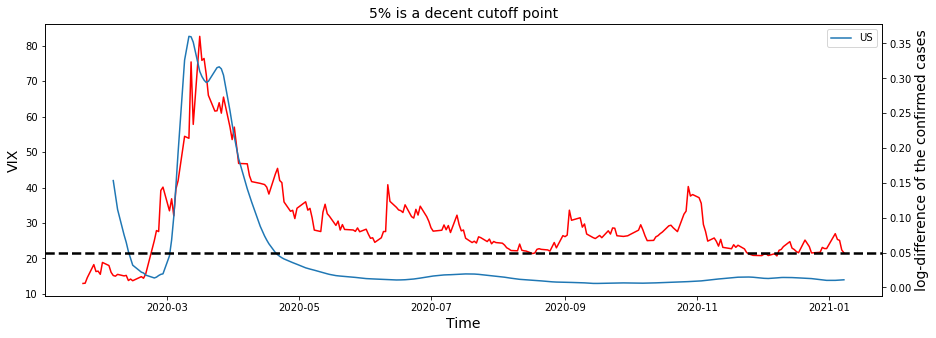

In [26]:
fig,ax = plt.subplots(figsize=(15,5))
# make a plot
ax.plot(data.index, data.VIX, color="red")
# set x-axis label
ax.set_xlabel("Time", fontsize=14)
# set y-axis label
ax.set_ylabel("VIX", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data.index, data['cases_growth_US'], label="US")
ax2.axhline(y=0.05, color='black', linestyle='--', linewidth=2.5)
ax2.set_ylabel("log-difference of the confirmed cases", fontsize=14)
ax2.set_title("5% is a decent cutoff point", fontsize=14)
plt.legend()
plt.show()

In [ ]:
# Code for Two-State Model
def make_state_model_AR1(data, observe):
    '''
    model for Two-State StoVol

    :param data: observation data
    :param observe: column name of y
    :return: PyMC model
    '''
    # Prepare data
    nstate = data['covid_state_US'].nunique()
    log_returns = data[observe].to_numpy()
    state_idx = data["covid_state_US"].to_numpy()

    with pm.Model() as model:
        # Data
        _returns = pm.Data("_returns", log_returns)
        _state_idx = pm.intX(pm.Data("state_idx", state_idx))
        # Prior
        scale = pm.InverseGamma("scale", alpha=2.5, beta=0.05, shape=nstate)
        log_vol = pm.GaussianRandomWalk('log_vol', mu=0, sigma=scale[_state_idx], shape=len(data))
        nu = pm.Exponential("nu", 0.1)
        # Likelihood
        returns = pm.StudentT("returns", nu=nu, lam=np.exp(-2 * log_vol), observed=_returns)
    return model

model_state = make_state_model_AR1(data, "log_returns")

with model_state:
    trace_state = pm.sample(2000, tune=2000, return_inferencedata=True)
    _var_names = ["scale", "nu"]
    model_diagnose(model_state, trace_state, _var_names)
    az.plot_trace(trace_state, var_names=_var_names)
    pp_state = pm.sample_posterior_predictive(trace_state)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, log_vol, scale]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 146 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Effective Sample Size (min across parameters)
	scale: 0.018404576957347707
	nu: 0.4265493642350365
rhat (max across parameters)
	scale: 1.008803802896167
	nu: 1.0002150757005746


The orange chains of scale paramters stands for $\sigma_\eta$ in
high-infection time while the blue chairs are in low-infection time.

The posterior distribution of the scale pamater $\sigma_\eta$ tells
a very attractive story -  the latent volatility process is mild and
steady under gentle contagious spread, but if covid-19 spreads quickly,
the volatility process also go wild.


In [ ]:
model_plot(data=data, trace=trace_state, pp=pp_state)

We compare the Two-state model vs the Random walk model.

The black paths are estimated volatility from two-state model,
and red paths arefrom random walk model.
The two-state model paths are enveloped by that of randome walk model,
illustrating that two-state model provide a narrower range of
posterior prediction.

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))

x_vals, y_vals = gen_xy(trace_state, data)
plt.plot(x_vals, y_vals, "black", alpha=0.002)

# comparison with baseline model
x_vals, y_vals = gen_xy(trace_RW, data)
plt.plot(x_vals, y_vals, "red", alpha=0.002)
plt.plot(data.index, data['real_3w_vol'], linewidth=2.5)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title="Estimated volatility over time - "
             "two-state model (black) provide better prediction than random walk model (red) ",
       xlabel="Date", ylabel="Volatility")
plt.show()

### Model Extension: Free-Scale Stochastic Volatility

The two-state model sheds light on the interrelation betwen market
volatility and COVID infection.

We are explorers and unsatisfied about the discrete state-space
representation of the model.

Hence we decide to do some heavylifting - introducing covid-19
as exogeneous variable to the volatiltiy process.

More specifically, we set the scale
parameter $\sigma_\eta$ to be a random walk process with a drift
determined by COVID infection and here comes the name
**Free-Scale Stochastic Volatility** as $\sigma_\eta$ is termed
*scale* in the literature.

##### Model Setting
The likelihood is given by
\begin{align*}
\qquad & log(y_t) \sim StudentT(\nu,\mu, e^{h_t}) \\
\end{align*}

The priors are given by
\begin{align*}
\qquad & \nu \sim Exp(0.1) \\
\qquad & \phi \sim \mathcal{N}(1, 1) \\
\qquad & h_{t} = \phi h_{t-1}+ \sigma_{\eta, t}* \eta_{t} \\
\qquad & \sigma_{\eta, t} = \sigma_{\eta, t-1} + \alpha*(lnC_t - lnC_{t-1}) + u_t \\
\end{align*}

We start from the easiest -  assume the log-vol process is a random walk ($\phi=1$)

In [ ]:
# Code for Free-Scale Stochastic Volatility assumeing a RW log-vol process

def make_covid_model(data, observe, col_covid="cases_growth_US", process='GRW'):
    '''
    model for Free-Scale StoVol

    :param data: observation data
    :param observe: column name of y
    :param col_covid: column name of covid data
    :param process: process of the scale paramter, can be GRW or AR1
    :return: PyMC model
    '''

    if data[col_covid].hasnans:
        raise ValueError(f"{col_covid} has NaN values")

    log_returns = data[observe].to_numpy()

    with pm.Model() as model:
        # Data
        _returns = pm.Data("_returns", log_returns)
        # _change_returns = pm.Data("_change_returns", data[observe_str], dims=observe_str, export_index_as_coords=True)
        _covid = pm.Data("covid", data[col_covid])

        # HyperPrior
        alpha = pm.Normal("alpha", mu=1, sigma=1, testval=np.random.random())
        scale = pm.GaussianRandomWalk("scale", mu=alpha*_covid, sigma=1, shape=len(data),
                                      testval=np.random.randint(low=1, high=10, size=len(data)))
        # Prior
        if process == 'GRW':  # scale follows a Gaussian Random Walk
            log_vol = pm.GaussianRandomWalk("log_vol", sigma=scale, shape=len(data),
                                        testval=np.random.randint(low=1, high=10, size=len(data)))
        elif process == 'AR1': # scale follows a AR1
            phi = pm.Beta("phi", alpha=20, beta=1.5)
            # phi = pm.Normal("phi", mu=1, sigma=1, testval=np.random.randint(low=1, high=10))
            log_vol = pm.AR1("log_vol", k=phi, tau_e=1 / pm.math.sqr(scale), shape=len(data)+1,
                             testval=np.random.randint(low=1, high=10, size=len(data)+1))[:-1]
        nu = pm.Exponential("nu", 0.1)

        # Likilihood
        returns = pm.StudentT("returns", nu=nu, lam=np.exp(-2 * log_vol), observed=_returns)
    return model

data_cmodel = data.dropna(subset=['cases_growth_US'])
model_covid = make_covid_model(data_cmodel, "log_returns")

with model_covid:
    trace_covid = pm.sample(3000, tune=4000, return_inferencedata=True)
    _var_names = ["alpha", "nu"]
    model_diagnose(model_covid, trace_covid, _var_names)
    az.plot_trace(trace_covid, var_names=_var_names)
    pp_covid = pm.sample_posterior_predictive(trace_covid)

In [ ]:
model_plot(data=data_cmodel, trace=trace_covid, pp=pp_covid)

The Free-Scale Stochastic Volatility behave disappointing - it's even
worse than the Two-state model, despite of much more complexity added.

We are wondering whether the moderate performance results from the
assmumption that log-vol process is a random walk, and hence
decide to sample the model with a AR1 log-vol process.

In [ ]:
# Code for Free-Scale Stochastic Volatility assumeing a AR log-vol process
data_cmodel = data.dropna(subset=['cases_growth_US'])
model_covid_AR = make_covid_model(data_cmodel, "log_returns", process='AR1')

with model_covid_AR:
    trace_covid_AR1 = pm.sample(3000, tune=4000, return_inferencedata=True)
    _var_names = ["alpha", "phi", "nu"]
    model_diagnose(model_covid_AR, trace_covid_AR1, _var_names)
    az.plot_trace(trace_covid, var_names=_var_names)
    pp_covid_AR = pm.sample_posterior_predictive(trace_covid_AR1)


##### NUTS vs Metropolis-Hasting
The NUTS don't work for our model seting. Based on debugging/error info,
our model are stuck where gradient are 0.

This naturally motivates use to use the Metropolis-Hasting algorithm,
which doesn't rely on gradients.

Also, the seminal paper
``Stochastic Volatility- Likelihood Inference and Comparison with ARCH Models``
 from Sangjoon Kim, Neil Shephard and Siddhartha Chib also use MH
 algorithm.

Hence, even with the following cavents from PyMC3 documentations, we
change the proposal step from NUTS to Metropolis-Hasting algo.

We increase the tuning and sampling periods drasticaly as MH algo is
fast.
<pre>
For almost all continuous models, NUTS should be preferred.

There are hard-to-sample models for which NUTS will be very slow causing
many users to use Metropolis instead.

This practice, however, is rarely successful. NUTS is fast on simple models but can be slow if the model is very complex
or it is badly initialized.

In the case of a complex model that is hard for NUTS, Metropolis, while faster, will have a very low effective sample
size or not converge properly at all.
A better approach is to instead try to improve initialization of NUTS, or reparameterize the model.
                                                                                        --PyMC3 Documentation
</pre>


In [ ]:
# Code for Free-Scale Stochastic Volatility assumeing a AR log-vol process
with model_covid_AR:
    # stepNUTS = pm.NUTS(vars=[model_covid_AR.alpha,
    #                          model_covid_AR.scale,
    #                          model_covid_AR.phi,
    #                          model_covid_AR.nu])
    # stepMH = pm.Metropolis(vars=[model_covid_AR.log_vol])
    # trace_covid_AR1 = pm.sample(8000, tune=8000, step=[stepNUTS,
    #                                                stepMH],
    #                         return_inferencedata=True)
    trace_covid_AR1 = pm.sample(8000, tune=8000, step=pm.Metropolis(),
                            return_inferencedata=True)
    _var_names = ["alpha", "nu", "phi"]
    model_diagnose(model_covid_AR, trace_covid_AR1, _var_names)
    az.plot_trace(trace_covid_AR1, var_names=_var_names)
    pp_covid_AR = pm.sample_posterior_predictive(trace_covid_AR1)

The Metropolis-Hasting algorithm generates decent posterior distributions
for $\alpha$ and $\nu$, but fail for $\phi$, also the posterior
prediction indicate strong overfitting problem. Our predictions
explode and hit the sky in some periods.

In [ ]:
model_plot(data=data_cmodel, trace=trace_covid_AR1, pp=pp_covid_AR, AR=True)

##### Conclusion